In [2]:
from os import path
from GP_modules.file_import import load_czi_file
from GP_modules.file_preprocess import channel_stack_crop
from GP_modules.GP_calc import GP_calculation, GP_calculation_chunked
from GP_modules.image_analysis import order_threshold_selector, final_visualization, save_results 


#ask for results folder
#get list of output folders
#if time series -> take frame 1, else get global stats
#segmentation for multi_GPMVs files
#output = violin plot

#ask for list of input folder with czi files
#get parent folder of the input folders -> results folder
#normal process for first file, then remember input parameters and apply them without choice for all other files
#important to delete variables betrween 2 iterations
#separate main function and workflow function 
#threshold out bottom slide



In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_folder = r"C:\Users\champ\Documents\Master_Thesis_CSI\data\images\250408_HELA_GPMVs_NR12S-250nM\Distribution_Results"

#get the list of folders in the results folder

results_folders = os.listdir(results_folder)

#remove the folders that are not GPMV folders
results_folders = [folder for folder in results_folders if "GPMV" in folder]






In [4]:
result_df = pd.DataFrame(columns=["Median", 
                                  "Order_percentage",
                                  "Ordered_pixels_nb",
                                  "Order_median",
                                  "Disordered_pixels_nb",   
                                  "Disorder_median",
                                  "Volume", 
                                  "Feret_diameter"])

for folder in results_folders:
    frames_path = None
    files = os.listdir(os.path.join(results_folder, folder))
    #find if there is a file ending with frames_GP_results.csv (meaning a multi frame input)

    for file in files:
        if file.endswith("frames_GP_results.csv"):
            #separate data of different labels, for each take first non_0 frame
            frames_path = os.path.join(results_folder, folder, file)
            df = pd.read_csv(frames_path)
            #get the values of columns Median, Order_percentages, Order_median, Ordered_pixels_nb, Disordered_median,  Disordered_pixels_nb, in row 0
            #add them to the result_df

            result_df = pd.concat([result_df, pd.DataFrame({"Median": [df.iloc[0]["Median"]], 
                                                            "Order_percentage": [df.iloc[0]["Order_percentages"]], 
                                                            "Order_median": [df.iloc[0]["Order_median"]], 
                                                            "Ordered_pixels_nb": [df.iloc[0]["Ordered_pixels_nb"]], 
                                                            "Disordered_median": [df.iloc[0]["Disordered_median"]], 
                                                            "Disordered_pixels_nb": [df.iloc[0]["Disordered_pixels_nb"]],
                                                            "Volume": [df.iloc[0]["Volume"]],
                                                            "Feret_diameter": [df.iloc[0]["Feret_diameter"]]})])

        
            
            

    if frames_path is None:
        for file in files:
            if file.endswith("global_GP_results.csv"):
                global_path = os.path.join(results_folder, folder, file)
                df = pd.read_csv(global_path)
                
                # Create a new dataframe with just the columns you need
                selected_columns = df[["Median", 
                              "Order_percentage", 
                              "Order_median", 
                              "Ordered_pixels_nb", 
                              "Disorder_median", 
                              "Disordered_pixels_nb",
                              "Volume", 
                              "Feret_diameter", 
                              "Order_threshold"]]
                
                result_df = pd.concat([result_df, selected_columns], ignore_index=True)

    

C:\Users\champ\AppData\Local\Temp\ipykernel_27376\2914673618.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, selected_columns], ignore_index=True)


In [5]:
#if a row in the result df has a value of less than 1000 in Volume, remove it
result_df = result_df[result_df["Volume"] > 10000]

In [6]:
#make sure all values in Order_threshold are the same
if len(result_df["Order_threshold"].unique()) > 1:
    print("There are different Order_threshold values in the result df")
    print(result_df["Order_threshold"].unique())
else:
    print("All Order_threshold values are the same")
    order_threshold = result_df["Order_threshold"].unique()[0]
    print("Order threshold is: ", order_threshold)

All Order_threshold values are the same
Order threshold is:  0.1


In [9]:
#get the first row of the dataframe
print(result_df)
#save the dataframe to a csv file in the results folder
result_df.to_csv(os.path.join(results_folder, "Distribution_results.csv"), index=False)

      Median  Order_percentage Ordered_pixels_nb  Order_median  \
0   0.080940         32.116679             43028      0.123028   
1   0.080940         32.116679             43028      0.123028   
2   0.063622         21.238459            118833      0.122449   
3   0.078370         36.796840            101999      0.136691   
4   0.093093         45.164308            167509      0.135593   
5   0.073482         33.290024            136822      0.129730   
6   0.032864         20.072065            122887      0.131868   
7   0.032258         20.322569             72377      0.132701   
8   0.065617         31.509434            141138      0.134921   
9   0.044586         29.308401             82662      0.144144   
11  0.082218         39.040048            103624      0.138381   
12  0.069486         30.966908            150183      0.132203   
13  0.094340         46.243225            137704      0.138728   
14  0.094340         46.212974             63608      0.142145   
15  0.0509

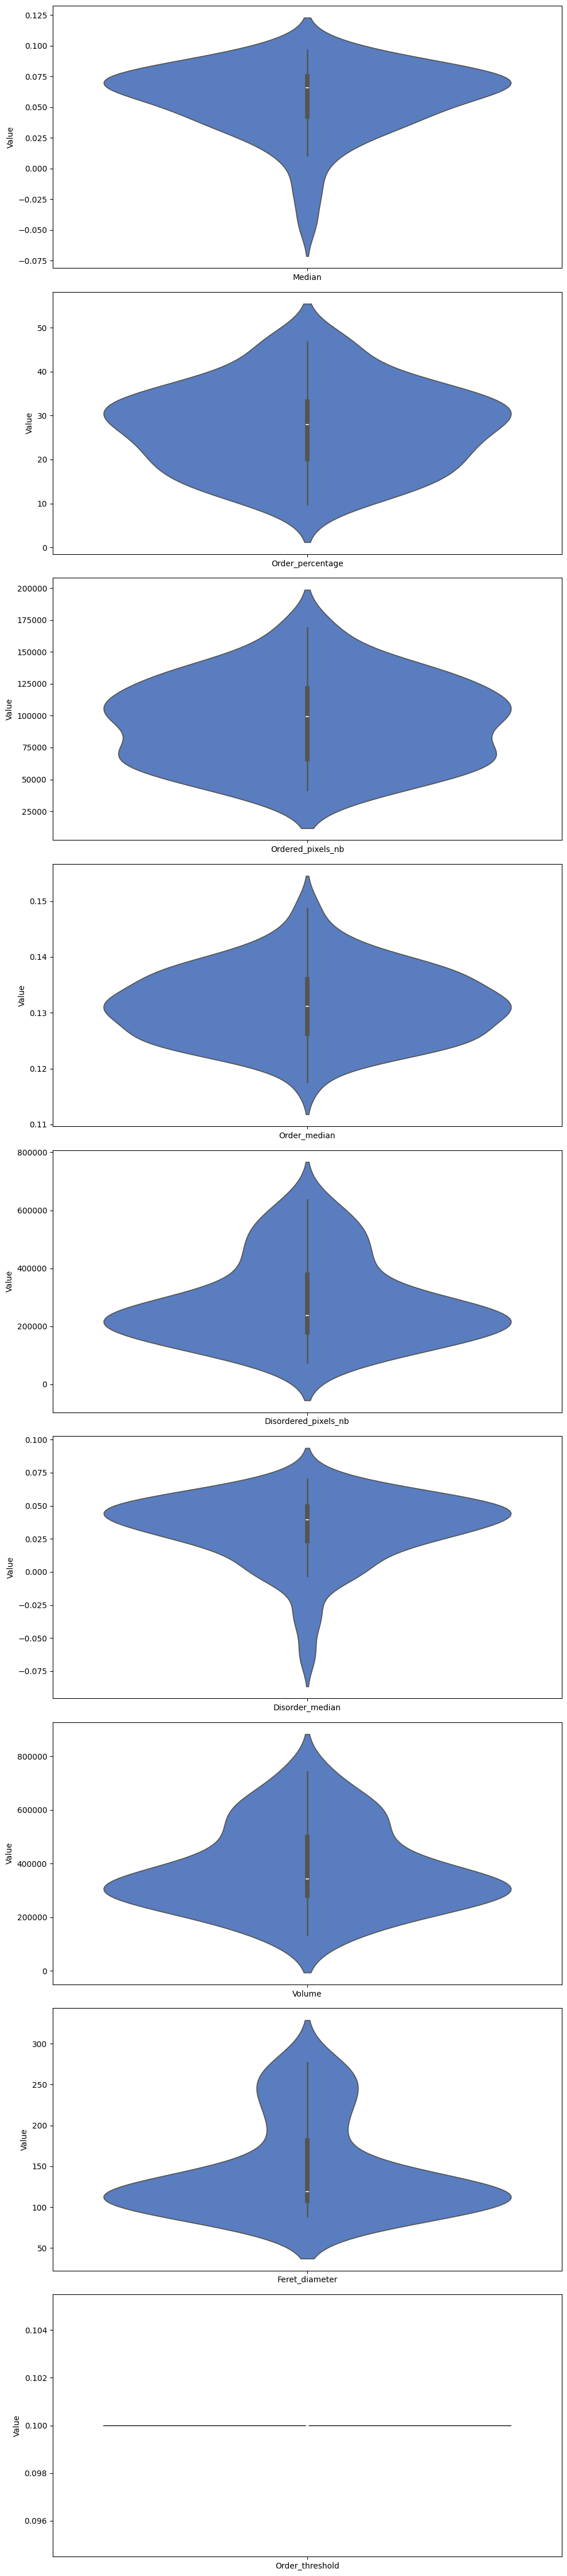

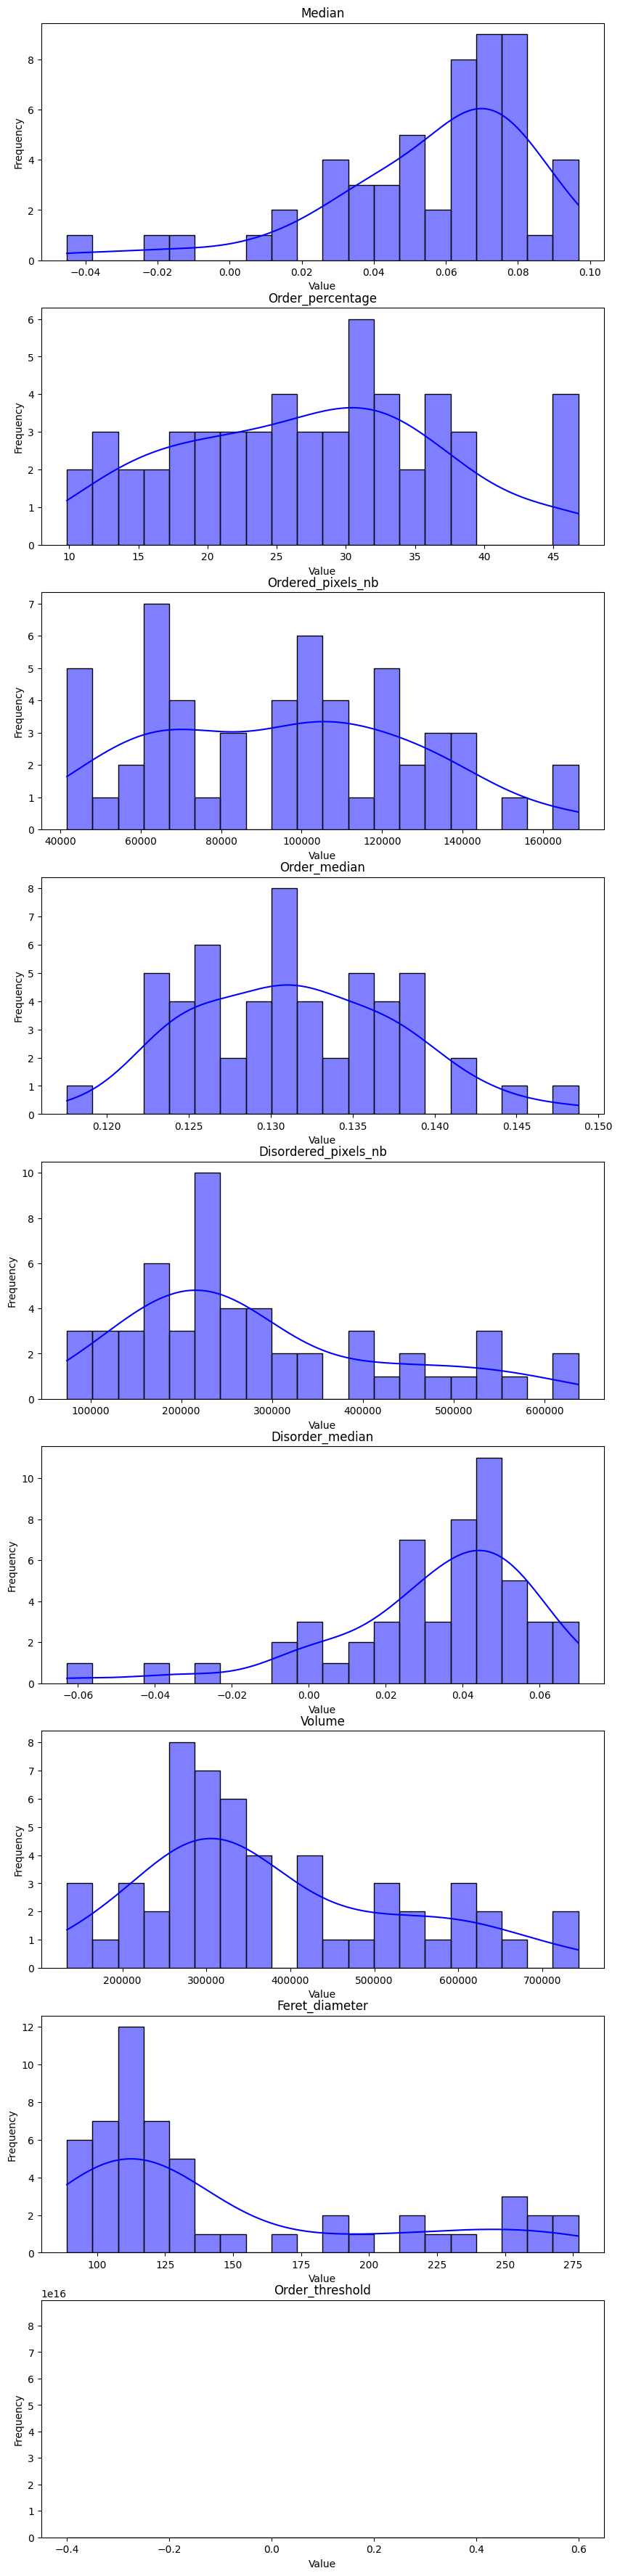

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming result_df is already defined
num_columns = len(result_df.columns)
results_melted = result_df.melt(var_name='Result Type', value_name='Value')

fig, axes = plt.subplots(nrows=num_columns, figsize=(10, 5 * num_columns))

for x, column in enumerate(result_df.columns):
    # Filter data for the current column
    column_data = results_melted[results_melted["Result Type"] == column]
    
    # Create violin plot for each column
    sns.violinplot(x="Result Type", y="Value", hue="Result Type", data=column_data, ax=axes[x], 
                   palette='muted', legend = False)
    
    #axes[x].set_title(column)
    axes[x].set_xlabel("")  # Remove x-label as it's redundant
    axes[x].set_ylabel("Value")
    
    # Just set the column name as the x-tick label
    axes[x].set_xticks([0])  # Set a single tick position
    axes[x].set_xticklabels([column])  # Set the column name as the label

plt.tight_layout()
plt.show()

#CREATE a histogram of the values of the columns
fig, axes = plt.subplots(nrows=num_columns, figsize=(10, 5 * num_columns))

for x, column in enumerate(result_df.columns):
    # Filter data for the current column
    column_data = result_df[column]
    
    # Create histogram for each column
    sns.histplot(column_data, bins=20, kde=True, ax=axes[x], color='blue')
    
    axes[x].set_title(column)
    axes[x].set_xlabel("Value")
    axes[x].set_ylabel("Frequency")
plt.show()

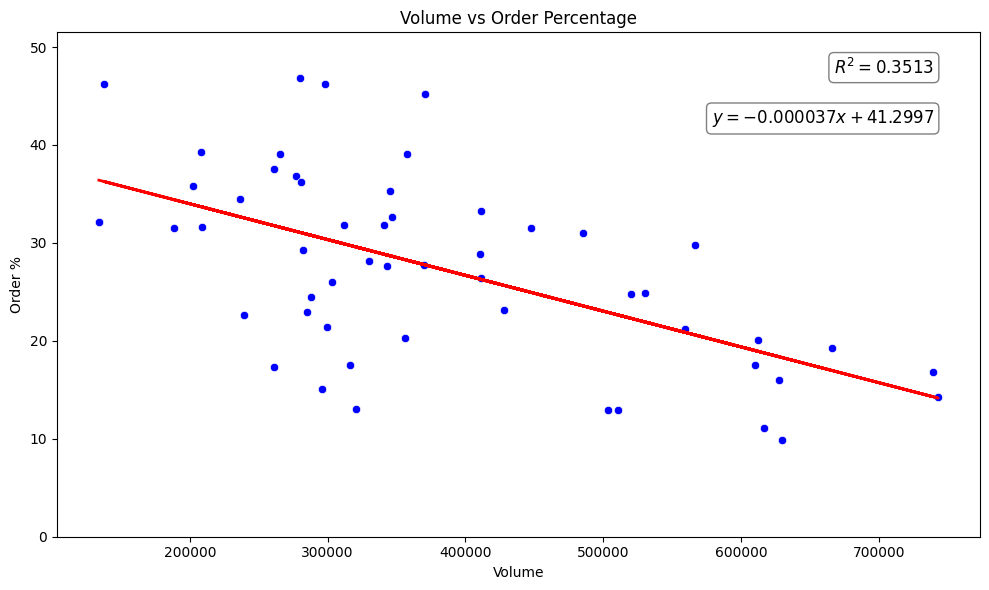

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(data=result_df, x="Volume", y="Order_percentage", color='blue', ax=ax)
ax.set_title("Volume vs Order Percentage")
ax.set_xlabel("Volume")
ax.set_ylabel("Order %")

# Calculate regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
X = result_df[["Volume"]]
y = result_df["Order_percentage"]
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)

# Add R-squared annotation
ax.text(0.95, 0.95, f'$R^2 = {r_squared:.4f}$', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Get coefficient and intercept
a = model.coef_[0]  # Extract the scalar value from the array
b = model.intercept_

# Add regression line equation annotation
ax.text(0.95, 0.85, f'$y = {a:.6f}x + {b:.4f}$', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Plot regression line
ax.plot(X, y_pred, color='red', linewidth=2)

#set x and y limits
#ax.set_xlim(0, result_df["Volume"].max() * 1.1)
ax.set_ylim(0, result_df["Order_percentage"].max() * 1.1)

plt.tight_layout()
plt.show()

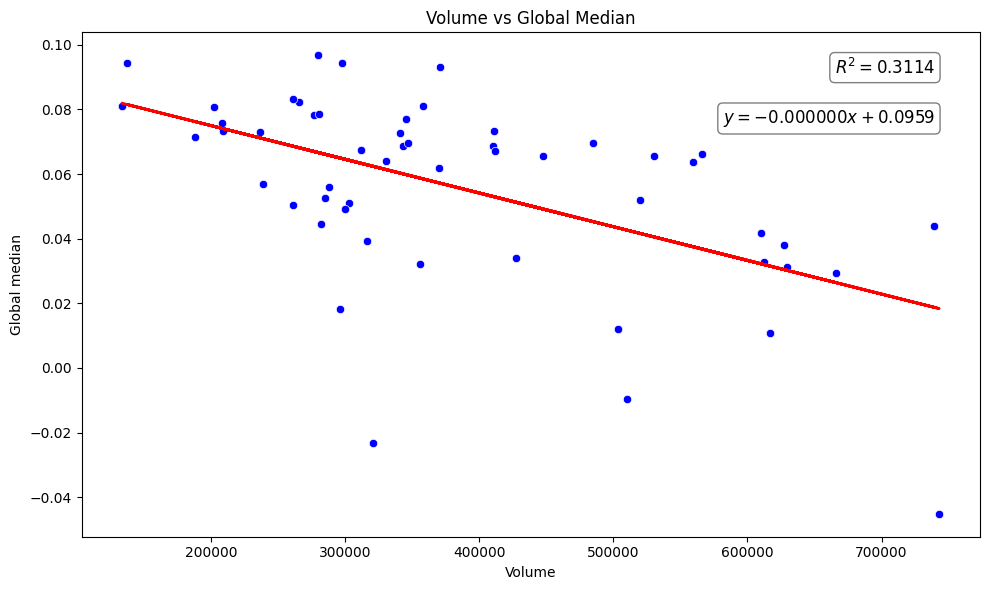

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(data=result_df, x="Volume", y="Median", color='blue', ax=ax)
ax.set_title("Volume vs Global Median")
ax.set_xlabel("Volume")
ax.set_ylabel("Global median")

# Calculate regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
X = result_df[["Volume"]]
y = result_df["Median"]
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)

# Add R-squared annotation
ax.text(0.95, 0.95, f'$R^2 = {r_squared:.4f}$', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Get coefficient and intercept
a = model.coef_[0]  # Extract the scalar value from the array
b = model.intercept_

# Add regression line equation annotation
ax.text(0.95, 0.85, f'$y = {a:.6f}x + {b:.4f}$', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Plot regression line
ax.plot(X, y_pred, color='red', linewidth=2)

plt.tight_layout()
plt.show()

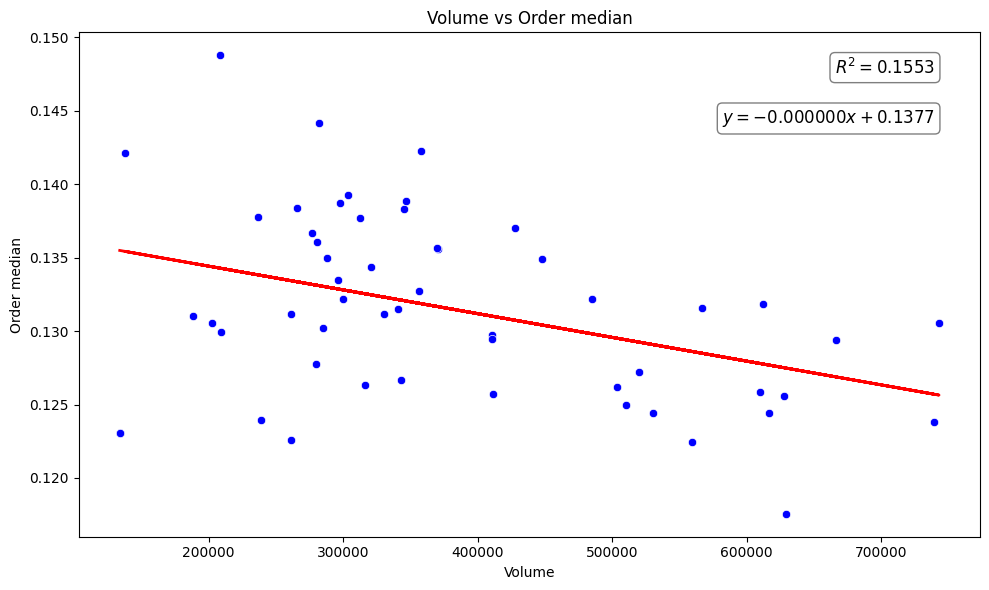

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(data=result_df, x="Volume", y="Order_median", color='blue', ax=ax)
ax.set_title("Volume vs Order median")
ax.set_xlabel("Volume")
ax.set_ylabel("Order median")

# Calculate regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
X = result_df[["Volume"]]
y = result_df["Order_median"]
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)

# Add R-squared annotation
ax.text(0.95, 0.95, f'$R^2 = {r_squared:.4f}$', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Get coefficient and intercept
a = model.coef_[0]  # Extract the scalar value from the array
b = model.intercept_

# Add regression line equation annotation
ax.text(0.95, 0.85, f'$y = {a:.6f}x + {b:.4f}$', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Plot regression line
ax.plot(X, y_pred, color='red', linewidth=2)

plt.tight_layout()
plt.show()

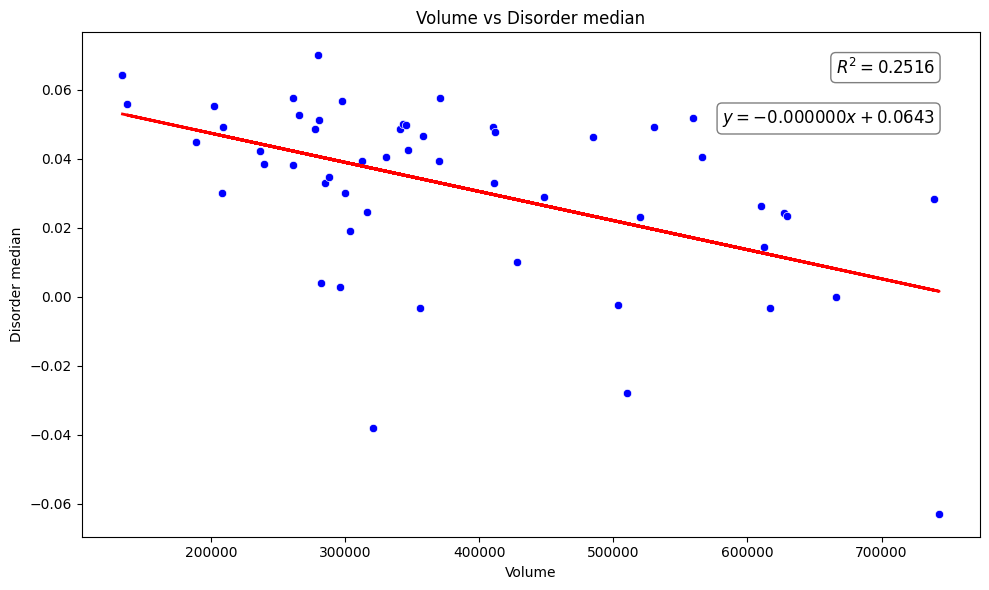

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(data=result_df, x="Volume", y="Disorder_median", color='blue', ax=ax)
ax.set_title("Volume vs Disorder median")
ax.set_xlabel("Volume")
ax.set_ylabel("Disorder median")

# Calculate regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
X = result_df[["Volume"]]
y = result_df["Disorder_median"]
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)

# Add R-squared annotation
ax.text(0.95, 0.95, f'$R^2 = {r_squared:.4f}$', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Get coefficient and intercept
a = model.coef_[0]  # Extract the scalar value from the array
b = model.intercept_

# Add regression line equation annotation
ax.text(0.95, 0.85, f'$y = {a:.6f}x + {b:.4f}$', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Plot regression line
ax.plot(X, y_pred, color='red', linewidth=2)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

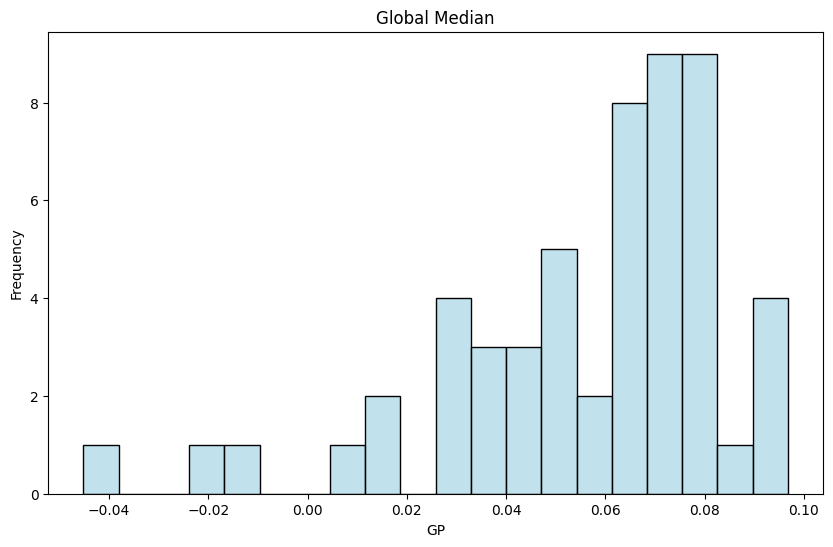

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

global_median = result_df["Median"]
    
# Create histogram for each column
sns.histplot(global_median, bins=20, ax=ax, color='LightBlue')

ax.set_title("Global Median")
ax.set_xlabel("GP")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

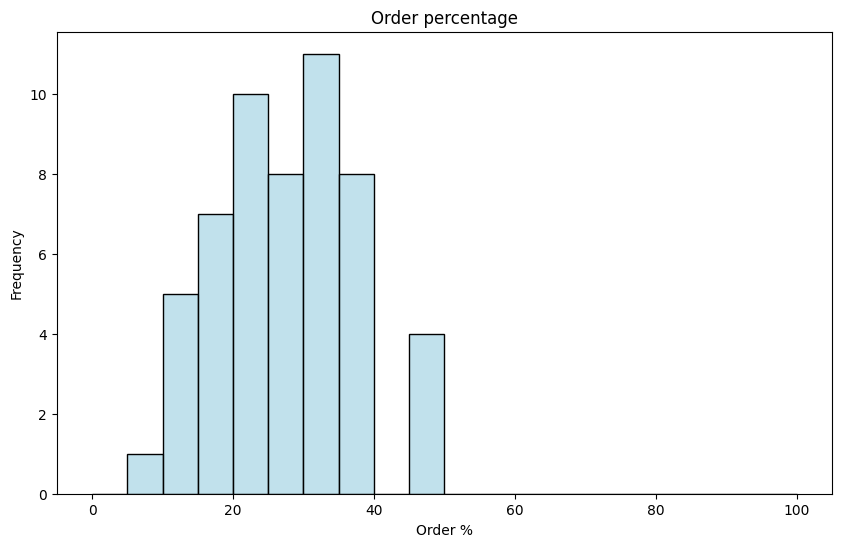

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

column_data = result_df["Order_percentage"]
    
# Create histogram for each column
sns.histplot(column_data, bins=20, ax=ax, color='LightBlue', binrange=(0, 100))

ax.set_title("Order percentage")
ax.set_xlabel("Order %")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

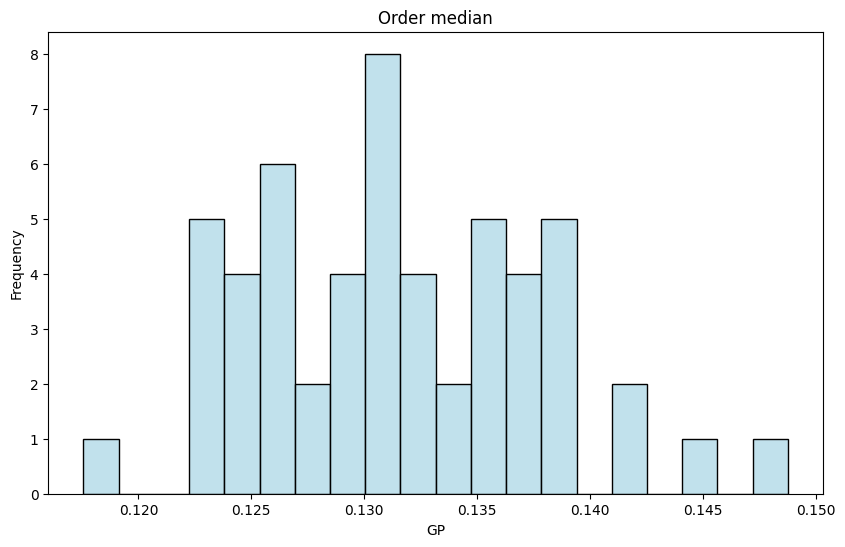

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

order_data = result_df["Order_median"]

# Create histogram for each column

sns.histplot(order_data, bins=20, ax=ax, color='LightBlue')

ax.set_title("Order median")
ax.set_xlabel("GP")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

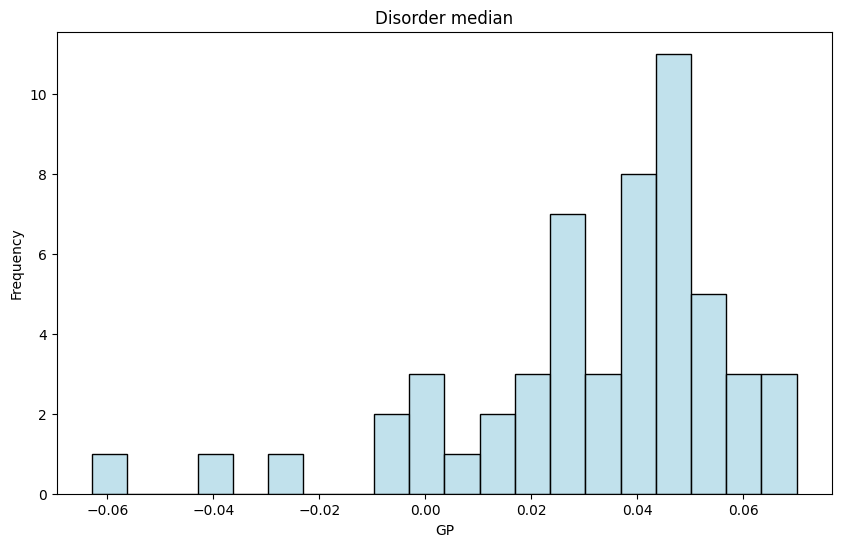

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

column_data = result_df["Disorder_median"]
    
# Create histogram for each column
sns.histplot(column_data, bins=20, ax=ax, color='LightBlue')

ax.set_title("Disorder median")
ax.set_xlabel("GP")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

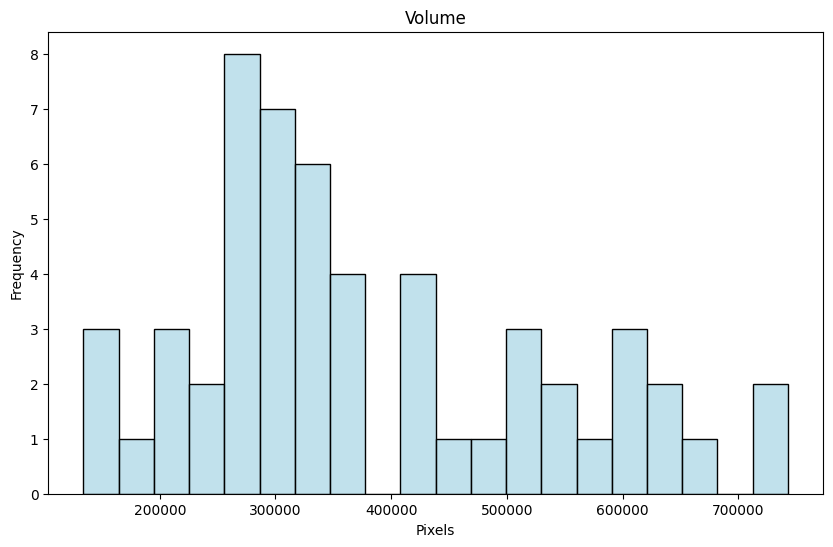

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

column_data = result_df["Volume"]
    
# Create histogram for each column
sns.histplot(column_data, bins=20, ax=ax, color='LightBlue')

ax.set_title("Volume")
ax.set_xlabel("Pixels")
ax.set_ylabel("Frequency")

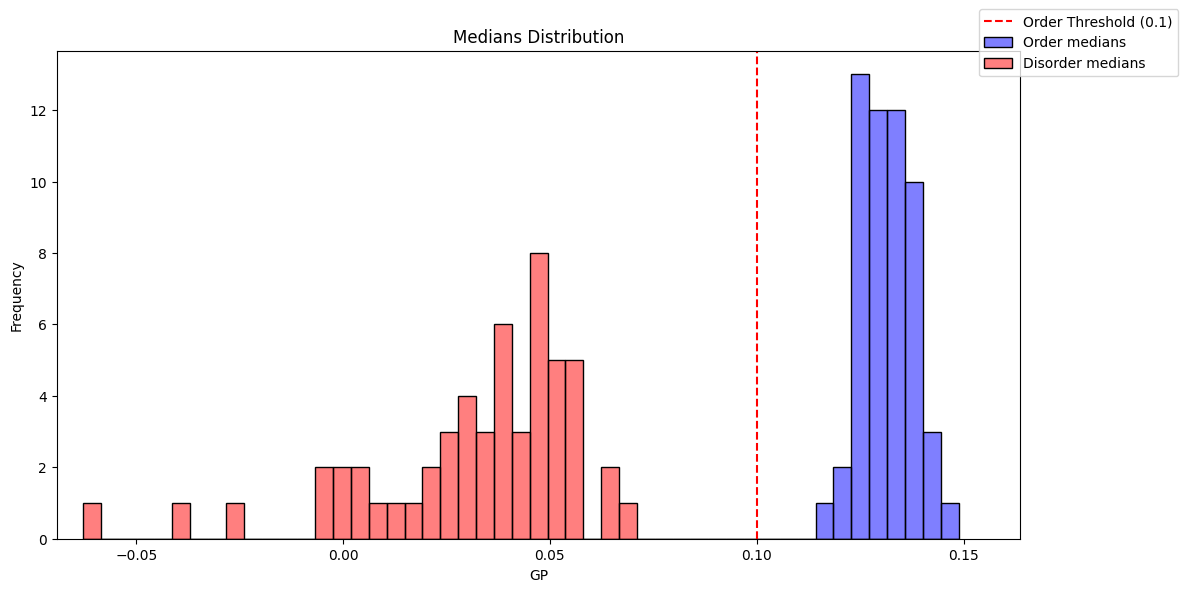

In [20]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(12, 6))

order_data = result_df["Order_median"]
disorder_data = result_df["Disorder_median"]

# Find common range for both histograms
min_val = min(order_data.min(), disorder_data.min())
max_val = max(order_data.max(), disorder_data.max())

# Create a common bin range with the same number of bins
common_bins = np.linspace(min_val, max_val, 50)

# Create histograms with the same binrange for fair comparison
sns.histplot(order_data, bins=common_bins, ax=ax, color='blue', alpha=0.5, label='Order medians')
sns.histplot(disorder_data, bins=common_bins, ax=ax, color='red', alpha=0.5, label='Disorder medians')
#sns.histplot(global_median, bins=common_bins, ax=ax, color='green', alpha=0.5, label='Whole object median')

# Add vertical line
threshold_line = ax.axvline(x=order_threshold, color='red', linestyle='--', label=f'Order Threshold ({order_threshold})')

# Set the x-axis limits explicitly
ax.set_xlim(min_val*1.1, max_val*1.1)

ax.set_title("Medians Distribution")
ax.set_xlabel("GP")
ax.set_ylabel("Frequency")

# Create legend with all elements
handles, labels = ax.get_legend_handles_labels()
#put the legend outside the plot
ax.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(0.95, 1.1))

plt.tight_layout()

Text(0, 0.5, 'Order %')

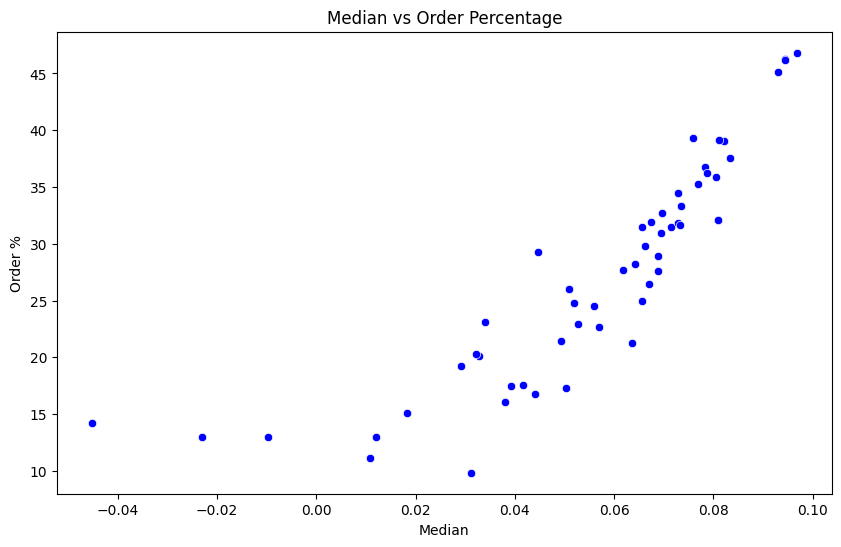

In [21]:
#plot median vs order percentage
fig, ax = plt.subplots(figsize=(10, 6))
# Create scatter plot
sns.scatterplot(data=result_df, x="Median", y="Order_percentage", color='blue', ax=ax)
ax.set_title("Median vs Order Percentage")
ax.set_xlabel("Median")
ax.set_ylabel("Order %")

    